#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "DOW_30_TICKER" relates with that.



#SETUP

In [ ]:
 # Install the unstable development version in Jupyter notebook:
 !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-qo6zzq2e
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-qo6zzq2e
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-v6dugldi/pyfolio_d09b15cad47641939468759e216b3ec5
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-v6dugldi/pyfolio_d09b15cad47641939468759e216b3ec5
     |████████████████████████████████| 172 kB 12.8 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 6.3 MB 51.8 MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=62457 sha256=2d004daf7feb1a708c343b78f076e76b745d675b040444f87c382d68f0baada2
  Stored in directory: /tmp/pip-ephem-wheel-cache-almlr3kb/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


#Collect Data

In [ ]:
print("==============Start Fetching Data===========")
df = YahooDownloader(
    start_date=config.START_DATE,
    end_date=config.END_DATE,
    ticker_list=config.DOW_30_TICKER,
).fetch_data()

==============Start Fetching Data===========
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1

#Feature Engineering

In [ ]:
print("==============Start Feature Engineering===========")
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=config.TECHNICAL_INDICATORS_LIST,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [ ]:
processed = fe.preprocess_data(df)


Successfully added technical indicators
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

# Training & Trading data split

In [ ]:
train = data_split(processed_full, config.START_DATE, config.START_TRADE_DATE)
trade = data_split(processed_full, config.START_TRADE_DATE, config.END_DATE)


# Calculate state action space


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

# ENV CREATE

In [ ]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 1000000, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
}

In [ ]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

#SET AGENT

In [ ]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

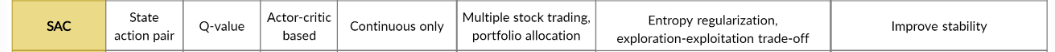

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=80000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 188      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | 946      |
|    critic_loss     | 123      |
|    ent_coef        | 0.187    |
|    ent_coef_loss   | -75.2    |
|    learning_rate   | 0.0001   |
|    n_updates       | 9963     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 375      |
|    total timesteps | 20128    |
| train/             |          |
|    actor_loss      | 348      |
|    critic_loss     | 2.27e+03 |
|    ent

#Save Model

In [ ]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_model') 
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=sI1YvCDFzpl3

In [ ]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


==============Start Trading===========
hit end!


In [ ]:
import os
cwd = os.getcwd()
cwd

'/content'

In [ ]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [ ]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" +"/perf_stats_all_" + now + ".csv")


==============Get Backtest Results===========
Annual return          0.067131
Cumulative returns     0.139063
Annual volatility      0.185367
Sharpe ratio           0.444514
Calmar ratio           0.271096
Stability              0.005616
Max drawdown          -0.247629
Omega ratio            1.086528
Sortino ratio          0.593226
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.874448
Daily value at risk   -0.023027
dtype: float64


 #Understanding Format of Variables:

In [ ]:
train

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.787006,746015200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2018-12-31,V,131.679993,132.440002,130.229996,129.906113,7976000.0,0.0,-2.418197,46.509202,-59.798289,15.829088,13.602307
2515,2018-12-31,VZ,55.529999,56.230000,55.070000,50.023243,15331800.0,0.0,-0.712368,49.637841,-70.556858,14.948583,13.602307
2515,2018-12-31,WBA,68.540001,68.720001,67.739998,62.303684,4870900.0,0.0,-3.272377,38.307186,-124.296956,57.411928,13.602307
2515,2018-12-31,WMT,92.669998,93.389999,92.250000,89.078613,7005800.0,0.0,-1.471619,48.351697,-17.692498,1.938208,13.602307


In [ ]:
trade

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.439735,148158800.0,2.0,-2.013469,37.867359,-91.575723,42.250808,51.408879
0,2019-01-02,AXP,93.910004,96.269997,93.769997,91.803406,4175400.0,2.0,-3.394947,41.204996,-97.765841,26.709417,51.408879
0,2019-01-02,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,2.0,-5.550592,47.010000,-21.712382,13.611972,51.408879
0,2019-01-02,CAT,124.029999,127.879997,123.000000,117.506577,4783200.0,2.0,-0.676421,48.229088,-5.177371,0.873482,51.408879
0,2019-01-02,CSCO,42.279999,43.200001,42.209999,39.496738,23833500.0,2.0,-0.939011,44.872565,-87.556999,29.529377,51.408879
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2020-12-31,V,218.399994,219.820007,216.199997,218.074188,5922200.0,3.0,2.242561,59.436993,232.375098,29.424279,9.382266
504,2020-12-31,VZ,58.060001,58.799999,58.020000,56.870125,12906300.0,3.0,-0.400808,46.770785,-155.773373,18.422305,9.382266
504,2020-12-31,WBA,39.330002,40.000000,39.029999,39.166107,7696000.0,3.0,0.008861,51.531879,-22.930249,0.403316,9.382266
504,2020-12-31,WMT,144.199997,144.270004,142.850006,142.989090,5938000.0,3.0,-0.850192,49.321966,-105.748106,14.356118,9.382266


In [ ]:
e_train_gym

In [ ]:
agent

In [ ]:
model_sac

In [ ]:
trained_sac

In [ ]:
e_trade_gym

In [ ]:
df_account_value

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.968911e+05
2,2019-01-04,1.004559e+06
3,2019-01-07,1.006449e+06
4,2019-01-08,1.010578e+06
...,...,...
500,2020-12-24,1.125980e+06
501,2020-12-28,1.131955e+06
502,2020-12-29,1.128045e+06
503,2020-12-30,1.128475e+06


In [ ]:
df_actions

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0,70,0,0,0,89,0,15,85,95,99,0,43,98,0,65,98,97,0,0,0,90,64,0,80,0,86,80,84,0
2019-01-03,0,48,0,0,0,97,0,-15,81,99,99,0,5,81,0,21,98,97,0,85,0,89,81,0,98,0,88,93,60,0
2019-01-04,0,98,0,0,0,88,0,0,96,89,97,0,83,97,0,-31,92,99,0,80,0,86,51,0,69,0,86,96,9,0
2019-01-07,0,98,0,0,0,90,19,0,83,87,89,0,0,93,0,51,98,98,0,45,0,97,53,0,99,0,95,92,98,0
2019-01-08,0,35,0,0,0,98,-8,81,82,98,98,0,95,98,0,65,74,99,0,77,0,72,43,0,-17,0,96,82,97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
